In [21]:
import numpy as np
from scipy.io import wavfile
from scipy import signal
import librosa
import librosa.core
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.image as img
import pylab
import os
from math import *

import IPython.display as ipd

from microfaune import audio
from microfaune import plot

# Functions (to add to microfaune package)

In [30]:
def file2spec(path_file, scale_spec = "linear", N_MELS=40, window_length=0.020, overlap=0.5, f_max=15000, duration=10):
    """ Compute spectogram from a wav or mp3 file.

           Parameters
            ----------
            path_file : str
                path to a wav or mp3 file.
            scale_spec : str
                scale used to use to compute spectogram, can be "linear" or "MEL".
            N_MELS : int
                Number of Mel bands to generate.
            window_length : float
                Length of the FFT window in seconds.
            overlap : float
                Overlap of the FFT windows.
            f_max : int
                Maximum frequency of the FFT domain.
            duration: int
                Duration of the sound to consider (starting at the beginning)

            Returns:
            -------
            spec : array-like
                Array of shape (frequency, time) containing the spectrogram.
            t : array-like
                Array of shape (time, 1) containing the time scale of spectogram.
                None if MEL scale is used
            f : array-like
                Array of shape (frequency, 1) containing the frequency scale of spectogram.
                None if MEL scale is used
        """
    
    # Load map3 or wav file
    
    if path_file[-4:] == ".wav":
        x_fs, x = audio.load_wav(path_file)
            
    elif path_file[-4:] == ".mp3":
        x, x_fs = librosa.core.load(path_file, sr = None)
        
    else:
        raise ValueError("Wrong file format, use mp3 or wav")
    
    shape = np.shape(x)
    # If the file contains several channel
    if len(shape)>1:
        x = np.sum(x,axis=1)

    # Derive FFT parameters
    N_FFT = int(window_length * x_fs) + 1
    HOP_LEN = int(overlap * window_length * x_fs) + 1

    # Compute spectograms
    if (scale_spec == "linear"):
        frequency_resolution = x_fs / N_FFT
        size_frequency_axis = 1 + floor(f_max / frequency_resolution)
        f, t, spec = signal.stft(x[:int(x_fs*duration)+1], fs=x_fs, nperseg=N_FFT, noverlap=HOP_LEN)
        # scipy returns a complex array, only the modulus is used in spectograms
        spec = np.abs(spec)
        # remove frequency above f_max
        if f[-1] > f_max:
            fsup_to_fmax = np.where(f>f_max)
            f = f[0:fsup_to_fmax[0][0]+1]
            spec = spec[0:fsup_to_fmax[0][0]+1,:]

    elif (scale_spec == "MEL"):
        # librosa library does not give access to t and f
        spec = librosa.feature.melspectrogram(x[:int(fs*duration)+1], sr=x_fs, n_fft=N_FFT, hop_length=HOP_LEN, n_mels=N_MELS)
        spec = np.abs(spec)
        t = None
        f = None

    else:
        raise ValueError(f"Wrong scale_spec parameter {scale_spec}, use linear or MEL")

    # Convert power to dB with the minimum as a reference, only positive dB
    spec = librosa.power_to_db(spec,ref=np.min(spec))

    
    return spec, t, f, x_fs




def plot_spec(spec, t, f, fs, scale_spec = "linear", window_length=0.20, N_MELS=40, overlap=0.5,
              plot_title="", fig_size=(20,5), save_fig=False, save_path="spec.png", plot_frequencies=False):
    
    """ Plot spectogram.

           Parameters
            ----------
            spec : array-like
                Array of shape (frequency, time) containing the spectrogram.
            t : array-like
                Array of shape (time, 1) containing the time scale of spectogram.
                None if MEL scale is used
            f : array-like
                Array of shape (frequency, 1) containing the frequency scale of spectogram.
                None if MEL scale is used
            fs : int
                Sampling frequency in Hz.
            scale_spec : str
                scale used to use to compute spectogram, can be "linear" or "MEL".
            N_MELS : int
                Number of Mel bands to generate.
            window_length : float
                Length of the FFT window in seconds.
            overlap : float
                Overlap of the FFT windows.
            plot_title : str
                Title of the plotted figure.
            fig_size : (int, int)
                Size of the plotted figure.
            save_fig : boolean
                True if the plot is saved, wrong otherwise.
            save_path : str
                Path of the saved figure.
            plot_frequencies : boolean
                True if median, minimum and maximum frequency are plotted on spectrograms, wrong otherwise.

            Returns:
            -------
            freq_median : int
                Median frequency of bird song in Hz.
                None if MEL scale is used
            freq_min : int
                Minimum frequency of bird song in Hz (10% quantile).
                None if MEL scale is used
            freq_max : int
                Maximum frequency of bird song in Hz (90% quantile).
                None if MEL scale is used
        """
    
    plt.set_cmap('inferno')
    pylab.rcParams['figure.figsize'] = fig_size
    
    # Derive FFT parameters
    HOP_LEN = int(overlap * window_length * fs) + 1
    
    if (scale_spec == "linear"):
        plt.pcolormesh(t, f, spec)
        plt.xlabel('Time [sec]')
        plt.ylabel('Frequency [Hz]')
        
        [freq_median, freq_min, freq_max] = find_most_used_frequencies(f, spec)
        
        if plot_frequencies:
            plt.plot([0, t[-1]], [freq_min, freq_min], 'k')
            plt.plot([0, t[-1]], [freq_median, freq_median], 'w')
            plt.plot([0, t[-1]], [freq_max, freq_max], 'k')
            
    elif (scale_spec == "MEL"):
        freq_median = None
        freq_min = None
        freq_max = None
        
        librosa.display.specshow(spec, x_axis='time', y_axis='mel', sr=fs, hop_length=HOP_LEN)
        
    else:
        raise ValueError(f"Wrong scale_spec parameter {scale_spec}, use linear or MEL")
    
        
    plt.colorbar(format='%+2.0f dB')
    plt.title(plot_title)
    if save_fig:
        plt.savefig(save_path)
    plt.show()
    plt.close()
        
    return [freq_median, freq_min, freq_max]


def find_most_used_frequencies(f, spec):
    
    """ Detect frequency used by the bird.

           Parameters
            ----------
            f : array-like
                Array of shape (frequency, 1) containing the frequency scale of spectogram.
            spec : array-like
                Array of shape (frequency, time) containing the spectrogram.

            Returns:
            -------
            freq_median : int
                Median frequency of bird song in Hz.
            freq_min : int
                Minimum frequency of bird song in Hz (10% quantile).
            freq_max : int
                Maximum frequency of bird song in Hz (90% quantile).
        """                 

    # Removing lower frequencies often saturated
    f = f[4:]
    spec = spec[4:,:]

    quantile_95 = np.quantile(spec, 0.95)
    pixels_above_q95 = np.where(spec > quantile_95)
    freq_most_used = f[pixels_above_q95[0]]

    freq_median = round(np.quantile(freq_most_used, 0.50), 0)
    freq_min = round(np.quantile(freq_most_used, 0.10), 0)
    freq_max = round(np.quantile(freq_most_used, 0.90), 0)
    
    return [freq_median, freq_min, freq_max]

# Format wav

In [8]:
file_name =  'audio/test_cite_u.wav'
ipd.Audio(file_name)

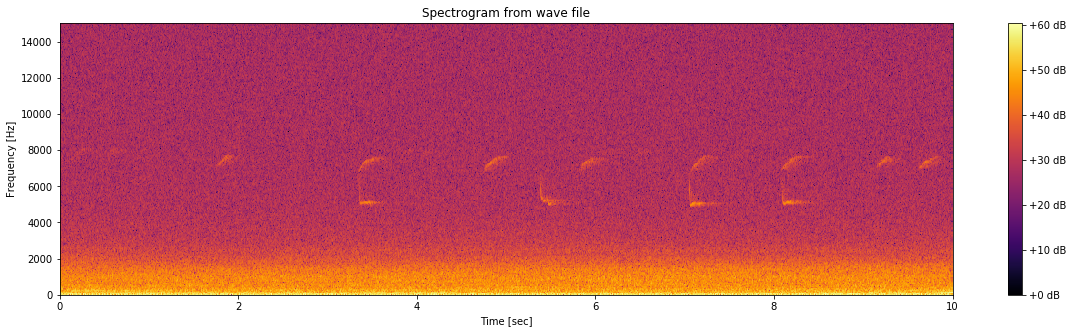

In [13]:
[spec, t, f, x_fs] = file2spec(file_name, scale_spec = "linear", window_length=0.020, overlap=0.5, duration=10)
[f1,f2,f3] = plot_spec(spec, t, f, x_fs, scale_spec = "linear", plot_title="Spectrogram from wave file", fig_size=(20,5), save_fig=True, save_path="spec_wav.png")

# Format MP3

In [31]:
file_name =  'audio/test_cite_u.mp3'
ipd.Audio(file_name)

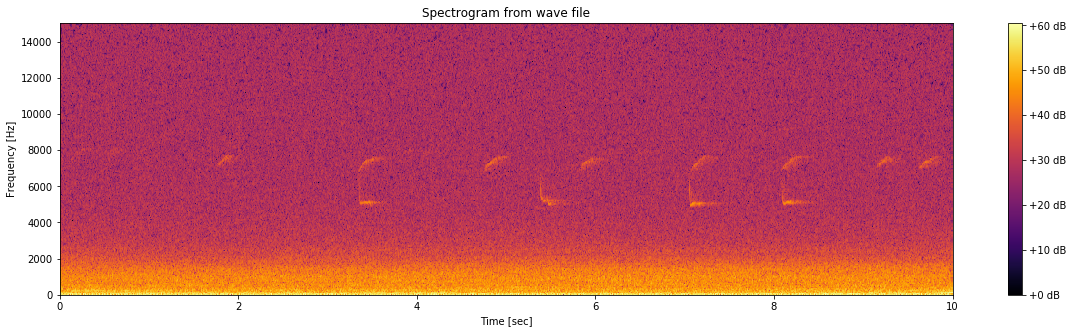

In [33]:
[spec, t, f, x_fs] = file2spec(file_name, scale_spec = "linear", window_length=0.020, overlap=0.5, duration=10)
[f1,f2,f3] = plot_spec(spec, t, f, x_fs, scale_spec = "linear", plot_title="Spectrogram from wave file", fig_size=(20,5), save_fig=True, save_path="spec_wav.png")

# Convert wav to mp3

In [37]:
from pydub import AudioSegment

file = open('list_file_names.txt', 'r')
file.readline()
list_file_names = file.read()
list_file_names = list_file_names.split('\n')

for i in range(52): # select index in the species list
    file_name = list_file_names[i]
    
    old_path = 'audio/species_wav/' + file_name + '.wav'
    new_path = 'audio/species_mp3/' + file_name + '.mp3'
    
    
    AudioSegment.from_wav(old_path).export(new_path, format="mp3")
    